In [3]:
import datasets
import numpy

lithium_threshold = 80

geochemical_analysis = datasets.geochemical_analysis()

In [4]:
#import reproducibility

# Best seed: 655
seed = 655

#reproducibility.seed_random(seed)

In [29]:
lithium_column = "LI"

X_geo = []#["LATITUDE", "LONGITUDE", "ALTITUDE"]
X_mass = ["SIO2", "TIO2", "AL2O3","FE2O3T","FEOT","MNO","MGO","CAO","NA2O","K2O","P2O5","H2O", "CR2O3"]
X_impurities = ["SC", "V","CR","CO","NI","CU","ZN","GA","MO","W","SN","SB","RB","SR","Y","NB","ZR","CS","CD","BA","LA","CE","PR","ND","SM","EU","GD","TB","DY","HO","ER","TM","YB","LU","HF","TA","PB","TH","U","AU","AG","S","AS_","SE","TE","GE","BI","TL","BE","B","F","CL","INDIUM"]
X_ratios = ["Rb_K2O", "Rb_Yb", "Rb_La", "K2O_MgO", "Rb_MgO", "U_Ba", "Ba_La", "U_Th", "Rb_Sn", "K2O_Sn", "Rb_MnO", "MnO_MgO"]
x_labels = X_geo + X_mass + X_impurities + X_ratios
y_labels = [lithium_column]

geochemical_analysis_lithium_measured = geochemical_analysis[x_labels + y_labels].dropna(subset=y_labels)
geochemical_analysis_complete = geochemical_analysis[x_labels + y_labels].dropna()
geochemical_analysis_incomplete = geochemical_analysis_lithium_measured.drop(geochemical_analysis_complete.index)
geochemical_analysis_train = geochemical_analysis_lithium_measured.sample(frac=0.8, random_state=seed)
geochemical_analysis_test = geochemical_analysis_lithium_measured.drop(geochemical_analysis_train.index)
geochemical_analysis_peru = geochemical_analysis[geochemical_analysis["COUNTRY"] == "PERU"][x_labels + y_labels].dropna(subset=y_labels)
geochemical_analysis_lithium_unmeasured = geochemical_analysis.drop(geochemical_analysis_lithium_measured.index)

x_train = geochemical_analysis_train[x_labels].to_numpy(numpy.float32)
y_train = geochemical_analysis_train[y_labels].to_numpy(numpy.float32).ravel()
x_test = geochemical_analysis_test[x_labels].to_numpy(numpy.float32)
y_test = geochemical_analysis_test[y_labels].to_numpy(numpy.float32).ravel()

In [30]:
import sklearn.ensemble

model = sklearn.ensemble.HistGradientBoostingRegressor(loss="squared_error", validation_fraction=0.2, min_samples_leaf=5, random_state=seed).fit(x_train, y_train)

print("Training Score", model.score(x_train, y_train))
print("Test Score", model.score(x_test, y_test))

from analysis import *
y_test_predicted = model.predict(x_test)
comparison, confusion_matrix = evaluate_performance(y_test, y_test_predicted, lithium_threshold)

Training Score 0.992054102330085
Test Score 0.7764210648970398
True Positives = 82
False Positives = 33
True Negatives = 1287
False Negatives = 26
accuracy = 0.9586834733893558
precision = 0.7130434782608696
recall = 0.7592592592592593
f1 = 0.7354260089686099


In [31]:
x_all = geochemical_analysis_lithium_measured[x_labels].to_numpy(numpy.float32)
y_all = geochemical_analysis_lithium_measured[y_labels].to_numpy(numpy.float32).ravel()
y_all_predicted = model.predict(x_all)

comparison, confusion_matrix = evaluate_performance(y_all, y_all_predicted, lithium_threshold)

True Positives = 534
False Positives = 53
True Negatives = 6471
False Negatives = 84
accuracy = 0.9808176981237748
precision = 0.909710391822828
recall = 0.8640776699029126
f1 = 0.8863070539419086


In [32]:
x_peru = geochemical_analysis_peru[x_labels].to_numpy(numpy.float32)
y_peru = geochemical_analysis_peru[y_labels].to_numpy(numpy.float32).ravel()
y_peru_predicted = model.predict(x_peru)
comparison, confusion_matrix = evaluate_performance(y_peru, y_peru_predicted, lithium_threshold)

True Positives = 518
False Positives = 53
True Negatives = 6279
False Negatives = 82
accuracy = 0.9805251009809579
precision = 0.9071803852889667
recall = 0.8633333333333333
f1 = 0.8847139197267292


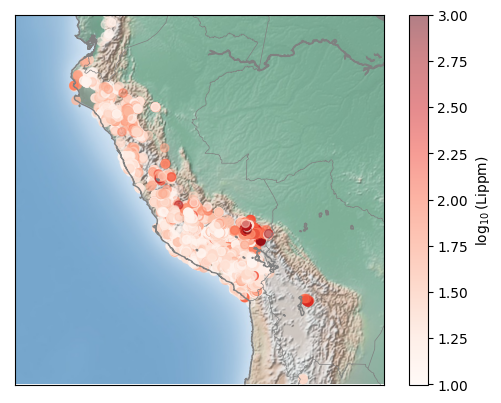

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

m = Basemap(projection='lcc', resolution='h', 
            lat_0=-12.23, lon_0=-73.536,
            width=2.5E6, height=2.5E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')

lat = geochemical_analysis['LATITUDE'].values
lon = geochemical_analysis['LONGITUDE'].values
li = geochemical_analysis['LI'].values

m.scatter(lon, lat, latlon=True,
          c=np.log10(li),
          cmap='Reds', alpha=0.5)

plt.colorbar(label=r'$\log_{10}({\rm Li ppm})$')
plt.clim(1, 3)

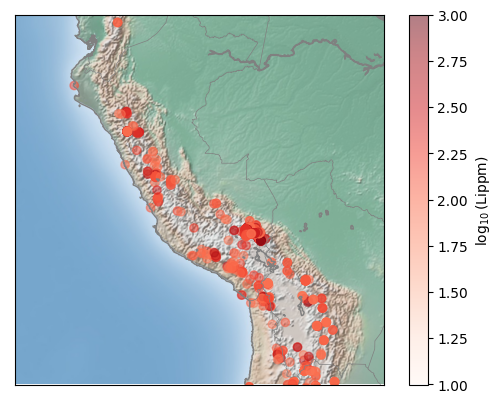

In [44]:
x_lithium_unmeasured = geochemical_analysis_lithium_unmeasured[x_labels].to_numpy(numpy.float32)
y_lithium_unmeasured = model.predict(x_lithium_unmeasured)

m = Basemap(projection='lcc', resolution='h', 
            lat_0=-12.23, lon_0=-73.536,
            width=2.5E6, height=2.5E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')

interesting_finds = y_lithium_unmeasured > 80

lat = geochemical_analysis_lithium_unmeasured['LATITUDE'][interesting_finds].values
lon = geochemical_analysis_lithium_unmeasured['LONGITUDE'][interesting_finds].values
li = y_lithium_unmeasured[interesting_finds]

m.scatter(lon, lat, latlon=True,
          c=np.log10(li),
          cmap='Reds', alpha=0.5)

plt.colorbar(label=r'$\log_{10}({\rm Li ppm})$')
plt.clim(1, 3)

In [46]:
x_full = geochemical_analysis[x_labels].to_numpy(numpy.float32)
y_full = model.predict(x_full)

In [47]:
geochemical_analysis["LI_PREDICTED"] = y_full

In [48]:
geochemical_analysis.shape

(23843, 105)

In [50]:
import pandas as pd

geochemical_analysis.to_csv("results_chemical_modelling.csv")